# Inverting gradient attack

We run the inverting gradient data poisoning attack by [Bouaziz et al.](https://arxiv.org/abs/2410.21453) We compare the effectiveness of machine unlearning as a defense, with a robust gradient aggregation rule.

We consider the same machine unlearning algorithms tested by [Pawelczyk et al.](https://arxiv.org/abs/2406.17216) and we use the $m$-KRUM aggregator introduced by [Blanchard et al.](https://arxiv.org/abs/1703.02757)

### Imports

In [1]:
from __future__ import annotations

from copy import deepcopy
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.classification import MulticlassAccuracy
from image_classification.nn import Logs
from image_classification.accel import BEST_DEVICE

Using cuda device


## Base learning settings

### Model

For quick prototyping, also consider using [`ShuffleNetV2`](https://arxiv.org/abs/1807.11164v1), a 300M-parameter model that is much smaller than [`ResNet18`](https://arxiv.org/abs/1704.06904). Experiments can be made on both models or on only one of them.

In [2]:
from image_classification.models import ResNet18, ShuffleNetV2
from image_classification.datasets import cifar10_train_test, cifar100_train_test

### Dataset

We use CIFAR-10 by default.

In [3]:
# Set to 10 for CIFAR-10, 100 for CIFAR-100
num_classes = 10

# The images are already normalized by these datasets
if num_classes == 10:
    get_train_test = cifar10_train_test
elif num_classes == 100:
    get_train_test = cifar100_train_test
else:
    raise ValueError(f"Can't find CIFAR dataset with {num_classes} classes")
print(f"Loading CIFAR-{num_classes}")

training_data, test_data = get_train_test(root='data')
N_test = len(test_data)
N_val = len(training_data) // 10
N_aux = N_val
N = len(training_data) - N_val - N_aux
# This works since training data is already shuffled
training_data, val_data, aux_data = training_data.split([N, N_val, N_aux])

batch_size = 100
N, N_val, N_aux, N_test

Loading CIFAR-10


(40000, 5000, 5000, 10000)

In [4]:
train_loader = DataLoader(training_data, batch_size, drop_last=True)
val_loader = DataLoader(val_data, batch_size, drop_last=True)
aux_loader = DataLoader(aux_data, batch_size, drop_last=True)

### Hyperparameters

In [5]:
criterion = CrossEntropyLoss()

## Inverting gradient attack

In [6]:
# Warning: reloading modules will create errors with `isinstance` checks
#from importlib import reload
#import image_classification.gradient_attack
#import inverting_gradient_attack
#import federated as fed
#reload(image_classification.gradient_attack)
#reload(inverting_gradient_attack)
#reload(fed)

In [7]:
from image_classification.gradient_attack import (
    GradientAttack,
    GradientEstimator, OmniscientGradientEstimator, ShadowGradientEstimator,
    SampleInit, SampleInitRandomNoise, LearningSettings, GradientInverter,
    Schedule, NeverUpdate
)
from inverting_gradient_attack import Pipeline, PipelineResults, Unlearning, Hyperparams
import federated as fed
#from federated import Aggregator, Mean, Krum
from inverting_gradient_attack import Aggregator, Mean, Krum # Avoids failing isinstance checks
from federated.utils import convert_bn_modules_to_gn

## Poisoning + Unlearning pipeline

In [8]:
def patch_network(network_factory: type[nn.Module]):
    """Patches a neural network factory to make it compatible to per-gradient backpropagation.
    
    This replaces a model's BatchNorm layers with GroupNorm.
    See `federated.utils` documentation for technical details.
    """
    def patch():
        return convert_bn_modules_to_gn(network_factory())
    
    return patch

In [9]:
def run_pipeline(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method: GradientAttack | None = None,
        poison_factor: float = 0.2,
        unlearning_method: Unlearning | None = None,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run a training pipeline with default settings.

    The training may include poisoning with an inverting gradient attack,
    and perform unlearning after training.

    Parameters:
        model_factory (Module type): the neural network class.
        aggregator (Aggregator): a gradient aggregation method.
        inversion_method (GradientAttack, optional): the gradient inversion method.
        poison_factor (float, optional): the proportion of poisons in the training data.
        unlearning_method (Unlearning, optional): the unlearning algorithm.

        training_hparams (dict, optional): training hyperparameter overrides.
        unlearning_hparams (dict, optional): unlearning hyperparameter overrides.

        quicktesting (bool, defaults to False): whether to use a small model,
            a smaller subset of the training dataset and less training epochs
            for quicker testing iterations. Overrides hyperparameters when relevant.

    Returns:
        out (tuple[nn.Module, PipelineResults]): the trained and possibly unlearned model
            and the pipeline results.
    """
    poisoning = inversion_method is not None
    unlearning = unlearning_method is not None

    if poisoning:
        inverter = GradientInverter(
            method = inversion_method,
            estimator = ShadowGradientEstimator(aux_loader),
            steps = 5,
            sample_init = SampleInitRandomNoise(training_data),
        )
    
    settings = LearningSettings(
        criterion,
        aggregator = deepcopy(aggregator),
        num_clean = batch_size,
        num_byzantine = int(poison_factor / (1. - poison_factor) * batch_size),
    )

    hparams = Hyperparams()
    hparams = dataclasses.replace(hparams, **training_hparams)

    if quicktesting:
        model_factory = ShuffleNetV2
        mini_train_set, _ = random_split(training_data, [0.1, 0.9])
        train_loader_ = DataLoader(mini_train_set, batch_size)
        hparams = dataclasses.replace(hparams, epochs=1)
        if poisoning:
            inverter.steps = 1
    else:
        train_loader_ = train_loader

    pipeline = Pipeline(settings, train_loader_, val_loader, hparams)
    if unlearning:
        pipeline.unlearning_hparams[unlearning_method].update(unlearning_hparams)
    print(pipeline)

    model = patch_network(model_factory)().to(BEST_DEVICE)

    if poisoning and unlearning:
        unlearner, results = pipeline.poison_and_unlearn(model, inverter, unlearning_method)
        model = unlearner
    elif poisoning:
        poisoned, results = pipeline.poison(model, inverter)
        model = poisoned
    else:
        assert not unlearning, "Cannot unlearn when there is no poisoning"
        trained, results = pipeline.train(model)
        model = trained 
    
    return model, results

### Normal training

In [10]:
def train(
        model_factory = ResNet18,
        aggregator = Mean(),
        training_hparams: dict = {},
        quicktesting: bool = False,
) -> tuple[nn.Module, PipelineResults]:
    """Train the model normally.
    
    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        poison_factor=0.0,
        training_hparams=training_hparams,
        quicktesting=quicktesting,
    )

### Training with data poisoning

This inverting gradient data poisoning attack can be defended by changing the aggregator to KRUM.

In [11]:
def poison(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        training_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poisoning pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        inversion_method=inversion_method,
        poison_factor=poison_factor,
        training_hparams=training_hparams,
        quicktesting=quicktesting,
    )

### Poisoning and then Unlearning

Machine unlearning is used against a gradient inversion data poisoning attack.

In [12]:
def poison_and_unlearn(
        model_factory = ResNet18,
        aggregator = Mean(),
        inversion_method = GradientAttack.ASCENT,
        poison_factor: float = 0.2,
        unlearning_method = Unlearning.NEG_GRAD_PLUS,
        training_hparams: dict = {},
        unlearning_hparams: dict = {},
        quicktesting: bool = False,
    ) -> tuple[nn.Module, PipelineResults]:
    """Run the poison-and-unlearn pipeline with default settings.

    See `run_pipeline` for details on the arguments.
    """
    return run_pipeline(
        model_factory,
        aggregator=aggregator,
        inversion_method=inversion_method,
        poison_factor=poison_factor,
        unlearning_method=unlearning_method,
        training_hparams=training_hparams,
        unlearning_hparams=unlearning_hparams,
        quicktesting=quicktesting,
    )

## Experiments

In [19]:
model, train_results = train(
    ShuffleNetV2,
    aggregator = Krum.with_learning_settings(batch_size, alpha = 0.05),
    training_hparams = dict(epochs=1),
    quicktesting=False, # quicktesting=True gives bad results (model outputs constant???)
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=11, num_selected=86), num_clean=100, num_byzantine=0), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})


Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Train loop: 100%|██████████| 40000/40000 [00:09<00:00, 4113.76it/s, accuracy=0.509, avg_loss=1.93]


Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 9592.57it/s, accuracy=0.411, avg_loss=1.65]


In [20]:
unlearner, poison_unlearn_results = poison_and_unlearn(
    ShuffleNetV2,
    aggregator = Krum.with_learning_settings(batch_size, alpha = 0.05),
    inversion_method = GradientAttack.ASCENT,
    poison_factor = 0.05,
    unlearning_method = Unlearning.NEG_GRAD_PLUS,
    training_hparams = dict(epochs=1),
    unlearning_hparams = dict(),
    quicktesting=False,
)

Pipeline(settings=LearningSettings(criterion=CrossEntropyLoss(), aggregator=Krum(num_byzantine=11, num_selected=86), num_clean=100, num_byzantine=5), train_loader=Dataloader(<len=40000>), val_loader=Dataloader(<len=5000>), hparams=Hyperparams(lr=0.001, weight_decay=0.0005, max_lr=0.1, batch_size=100, epochs=1, num_classes=10, top_k=1, criterion=CrossEntropyLoss()), unlearning_hparams={<Unlearning.GRADIENT_DESCENT: 0>: {'lr': 0.001, 'epochs': 1}, <Unlearning.NOISY_GRADIENT_DESCENT: 2>: {'lr': 0.001, 'epochs': 1, 'noise_scale': 0.00031622776601683794}, <Unlearning.GRADIENT_ASCENT: 1>: {'lr': 1e-05, 'epochs': 1}, <Unlearning.NEG_GRAD_PLUS: 3>: {'lr': 0.001, 'beta': 0.999, 'epochs': 1}, <Unlearning.CFK: 4>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.EUK: 5>: {'k': 6, 'lr': 0.001, 'epochs': 0}, <Unlearning.SCRUB: 6>: {'max_steps': 1, 'steps': 1, 'alpha': 0.1, 'beta': 0.01, 'gamma': 0.9}})
Poisoning GradientInverter(method=GradientAttack.ASCENT, estimator=<image_classification.gradient_

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/40000 [00:00<?, ?it/s]

Test epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 5000/5000 [00:00<00:00, 7814.20it/s, accuracy=0.353, avg_loss=1.87]
Running NEG_GRAD_PLUS with unlearning_hparams={'lr': 0.001, 'beta': 0.999, 'epochs': 1})


NegGrad+ epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

NegGrad+:   0%|          | 0/2000 [00:00<?, ?it/s]

In [47]:
from torchmetrics import Metric

def plot_accuracy(
        train_metrics: list[dict[str, Metric]],
        val_metrics: list[dict[str, Metric]] = None,
        ax: plt.Axes = None,
    ):
    # Mean accuracy per step
    # TODO: plot moving average or epoch tracking average instead
    train_acc_per_step_per_epoch = [
        epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
        for epoch_metrics in train_metrics
    ]
    train_acc_per_step = torch.cat(train_acc_per_step_per_epoch).numpy(force=True)
    ax.plot(np.arange(len(train_acc_per_step)), train_acc_per_step, label='Train accuracy')
    
    if val_metrics:
        val_acc_per_step_per_epoch = torch.vstack([
            epoch_metrics['MetricTracker'].compute_all()['accuracy'].mean(dim=1)
            for epoch_metrics in val_metrics
        ]).numpy(force=True)
        val_acc_per_epoch = val_acc_per_step_per_epoch.mean(axis=1)
        val_acc_std_per_epoch = val_acc_per_step_per_epoch.std(axis=1)

        epoch_end_steps = np.cumsum(list(map(len, train_acc_per_step_per_epoch)))
        ax.scatter(epoch_end_steps, val_acc_per_epoch, label='Validation accuracy', c='orange')
        ax.errorbar(epoch_end_steps, val_acc_per_epoch, yerr=val_acc_std_per_epoch, c='orange')
    
    ax.set_xlabel("Step")
    ax.set_ylabel("Mean accuracy")
    ax.set_ylim((0.0, 1.0))
    ax.legend()

def display_logs(logs: Logs, ax: plt.Axes):
    plot_accuracy(logs.train_metrics, logs.val_metrics, ax=ax)

def display_pipeline_results(results: PipelineResults):
    if results.unlearning:
        assert results.poisoning

        fig, axes = plt.subplots(nrows=1, ncols=2)

        display_logs(results.train_logs, ax=axes[0])
        axes[0].set_title("Training accuracy (poisoning)")

        display_logs(results.unlearn_logs, ax=axes[1])
        axes[1].set_title("Training accuracy (unlearning)")

        fig.tight_layout()
    
    else:
        ax = plt.subplot()
        display_logs(results.train_logs, ax=ax)

        label = "poisoning" if results.poisoning else "clean"
        ax.set_title(f"Training accuracy ({label})")

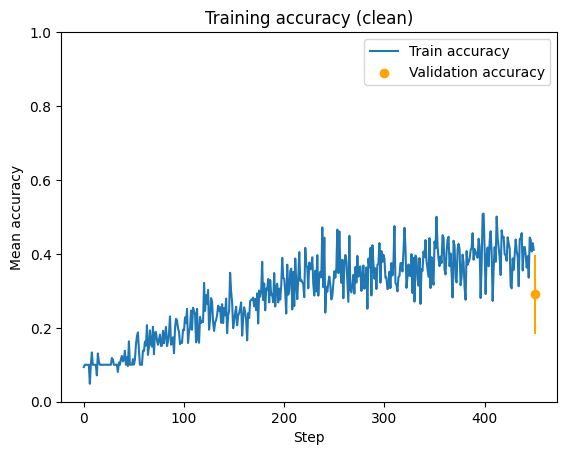

In [48]:
display_pipeline_results(train_results)

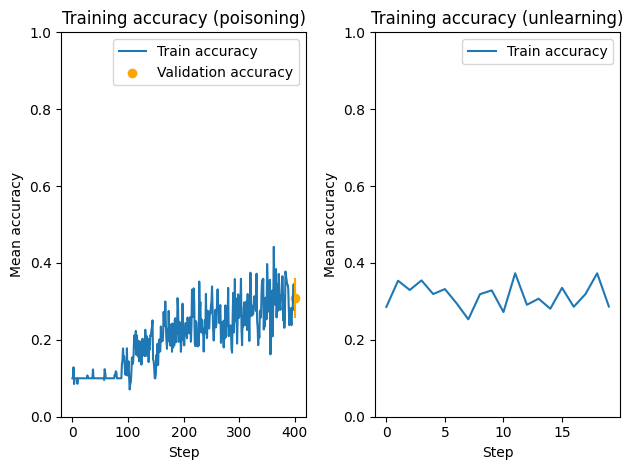

In [49]:
display_pipeline_results(poison_unlearn_results)

In [50]:
poison_unlearn_results.unlearn_logs.train_metrics

[{'MetricTracker': MetricTracker(
    (0-20): 21 x MetricCollection(
      (accuracy): MulticlassAccuracy()
    )
  )}]

TO CHECK:
- metric is correctly computed
- plot validation accuracy